# Master's thesis - Lukas Meuris - graphCast evaluation

This notebook contains the code to evaluate the models. 


In [ ]:
#!pip install git+https://github.com/google-research/weatherbench2.git

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import xarray as xr

import optax

import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import weatherbench2
from weatherbench2 import config

import matplotlib.pyplot as plt

# Specify input datasets



In [2]:
# load obs data:
relative_path = "ERA5_data/1959-2022-6h-64x32_equiangular_conservative.zarr"
obs_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
# obs_data = xr.open_zarr(obs_path)
# obs_data

In [3]:
#load forecast data:
# """!change predictions path"""
# relative_path = "predictions/pred_64x32_2020_mae2.zarr"
# pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
# pred_data = xr.open_zarr(pred_path)
# pred_data = pred_data.rename({'lon': 'longitude','lat': 'latitude'})

In [4]:
"""!change predictions path"""
relative_path = "predictions/pred_64x32_2020_mae2_eval.zarr"
pred_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
pred_data.to_zarr(pred_path, mode='w')
pred_data

<xarray.Dataset>
Dimensions:                       (time: 1465, batch: 1, longitude: 64,
                                   latitude: 32, prediction_timedelta: 41,
                                   level: 13)
Coordinates:
  * latitude                      (latitude) float64 -87.19 -81.56 ... 87.19
  * level                         (level) int64 50 100 150 200 ... 850 925 1000
  * longitude                     (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta          (prediction_timedelta) timedelta64[ns] 00:0...
  * time                          (time) datetime64[ns] 2020-01-01 ... 2021-0...
Dimensions without coordinates: batch
Data variables: (12/18)
    10m_u_component_of_wind       (time, batch, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 32, 32, 41), meta=np.ndarray>
    10m_v_component_of_wind       (time, batch, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 32, 32, 41), meta=np.ndarray>
    2m_temperature                (time, batch, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 32, 32, 41), meta=np.ndarray>
    day_progress_cos              (time, prediction_timedelta, batch, longitude) float32 dask.array<chunksize=(1, 41, 1, 64), meta=np.ndarray>
    day_progress_sin              (time, prediction_timedelta, batch, longitude) float32 dask.array<chunksize=(1, 41, 1, 64), meta=np.ndarray>
    geopotential                  (time, batch, level, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 7, 32, 16, 41), meta=np.ndarray>
    ...                            ...
    total_precipitation_6hr       (time, batch, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 32, 32, 41), meta=np.ndarray>
    u_component_of_wind           (time, batch, level, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 7, 32, 16, 41), meta=np.ndarray>
    v_component_of_wind           (time, batch, level, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 7, 32, 16, 41), meta=np.ndarray>
    vertical_velocity             (time, batch, level, longitude, latitude, prediction_timedelta) float32 dask.array<chunksize=(1, 1, 7, 32, 16, 41), meta=np.ndarray>
    year_progress_cos             (time, prediction_timedelta, batch) float32 dask.array<chunksize=(1, 41, 1), meta=np.ndarray>
    year_progress_sin             (time, prediction_timedelta, batch) float32 dask.array<chunksize=(1, 41, 1), meta=np.ndarray>

In [5]:
# load climatology:
relative_path = "ERA5_data/climatology.zarr"
climatology_path = os.path.join(os.path.dirname(os.getcwd()), relative_path)
climatology = xr.open_zarr(climatology_path)
climatology

<xarray.Dataset>
Dimensions:                                         (hour: 4, dayofyear: 366,
                                                     longitude: 64,
                                                     latitude: 32, level: 13)
Coordinates:
  * dayofyear                                       (dayofyear) int64 1 ... 366
  * hour                                            (hour) int64 0 6 12 18
  * latitude                                        (latitude) float64 -87.19...
  * level                                           (level) int64 50 ... 1000
  * longitude                                       (longitude) float64 0.0 ....
Data variables: (12/53)
    10m_u_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_wind_speed                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_dewpoint_temperature                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_temperature                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    above_ground                                    (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    ...                                              ...
    volumetric_soil_water_layer_1                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_2                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_3                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_4                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    vorticity                                       (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    wind_speed                                      (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>

# Set up WeatherBench configuration

Next, we will define a bunch of configuration instances to specify exactly what we want to evaluate.

## data configuration
The file paths are defined in a Paths config object, alongside an output directory:

In [6]:
paths = config.Paths(
    forecast=pred_path,
    obs=obs_path,
    output_dir='../evaluation/',   # Directory to save evaluation results
)

In addition, we specify a Selection object that selects the variables and time period to be evaluated.

In [7]:
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

Together they make up the Data config:

In [8]:
data_config = config.Data(selection=selection, paths=paths)

#### Evaluation configuration

Next, we can defined which evaluation we want to run. To do so, we can define a dictionary of `config.Eval`s, each of which will be evaluated separately and saved to a different file. Eval instances contain the metrics objects, defined in metrics.py.

Note that for ACC, we additionally need to pass the climatology opened earlier.

The evaluation configs also have an option to evaluate particular regions, such as a geographical lat-lon box. These are defined as region objects defined in regions.py. All regions will be evaluated separately and saved as an additional dimension in the dataset. If no region is specified, evaluation will be done globally.

In [9]:
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
}

"""!change save path"""
eval_configs = {
  'mae2': config.Eval(
      metrics={
          'mse': MSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}

### Evaluate

Now, we are already done and can run the evaluation. We can do so in memory for smaller datasets or as a Beam pipeline (recommended for anything larger than 64x32 resolution).

In [10]:
from weatherbench2.evaluation import evaluate_in_memory

evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes

/home/jupyter-lukas/.conda/envs/MTLMenv/lib/python3.12/site-packages/apache_beam/__init__.py:74: UserWarning: This version of Apache Beam has not been sufficiently tested on Python 3.12. You may encounter bugs or missing features.
  warnings.warn(


### Results
Results are saved as NetCDF files under the name of the eval config.

In [11]:
"""!change save path"""
results = xr.open_dataset('../evaluation/mae2.nc')
results

<xarray.Dataset>
Dimensions:         (lead_time: 41, level: 3, metric: 2, region: 1, batch: 1)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 0...
  * level           (level) int32 500 700 850
  * metric          (metric) object 'acc' 'mse'
  * region          (region) object 'global'
Dimensions without coordinates: batch
Data variables:
    2m_temperature  (metric, region, batch, lead_time) float64 ...
    geopotential    (metric, region, batch, level, lead_time) float64 ...

Note that to compute the RMSE, we follow ECMWF's convention by taking the square root after the time mean. To do this in WB2, first compute the MSE and then take the square root of the saved MSE results

In [12]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

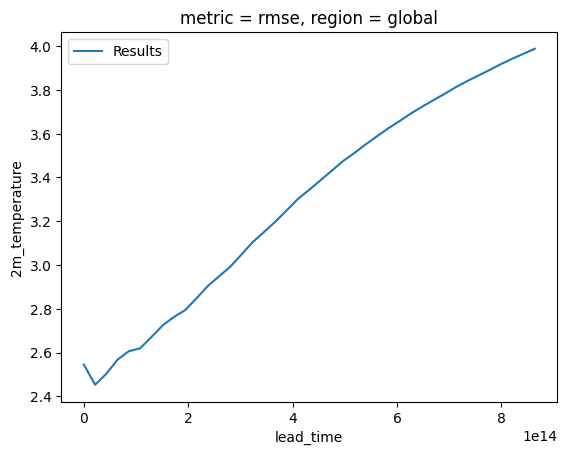

In [13]:
# Plot the dataset
results['2m_temperature'].sel(metric='rmse', region='global').plot(label='Results')
# Add legend
plt.legend()
# Show the plot
plt.show()

# compare results

In [14]:
results_mse1 = xr.open_dataset('../evaluation/mse1.nc')
results_mse2 = xr.open_dataset('../evaluation/mse2.nc')
results_mae1 = xr.open_dataset('../evaluation/mae1.nc')
results_mae2 = xr.open_dataset('../evaluation/mae2.nc')

In [15]:
results_mse1 = xr.concat(
    [results_mse1,
    results_mse1.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_mse2 = xr.concat(
    [results_mse2,
    results_mse2.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_mae1 = xr.concat(
    [results_mae1,
    results_mae1.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)
results_mae2 = xr.concat(
    [results_mae2,
    results_mae2.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5],
    dim='metric'
)

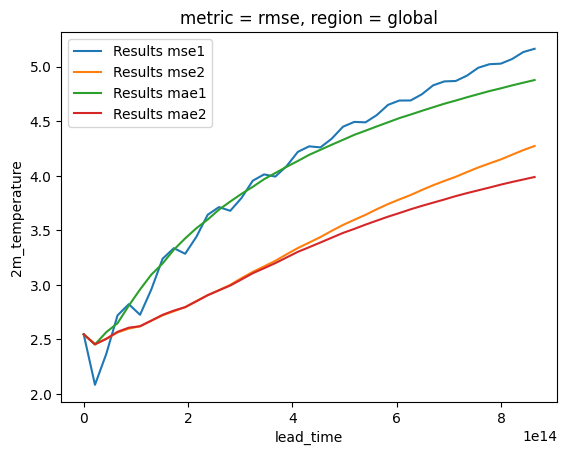

In [16]:
#plot the datasets:
results_mse1['2m_temperature'].sel(metric='rmse', region='global').plot(label='Results mse1')
results_mse2['2m_temperature'].sel(metric='rmse', region='global').plot(label='Results mse2')
results_mae1['2m_temperature'].sel(metric='rmse', region='global').plot(label='Results mae1')
results_mae2['2m_temperature'].sel(metric='rmse', region='global').plot(label='Results mae2')

# Add legend
plt.legend()
# Show the plot
plt.show()